In [336]:
# kütüphaneleri yükledik
from learntools.time_series.utils import (plot_periodogram, seasonal_plot, plot_lags, make_lags, make_leads,
                                          make_multistep_target, plot_multistep)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from sklearn.multioutput import RegressorChain

from hybrid_model import BoostedHybrid

import warnings

warnings.simplefilter('ignore')

In [376]:
# belli tanımlamaları yaptık ve datasetleri çektik
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
store_sales = pd.read_csv(
    'store-sales-time-series-forecasting\\train.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint64',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

### Time-step feature

In [ ]:
df = average_sales.to_frame()
time = np.arange(len(df.index))

df['time'] = time

X = df.loc[:, ['time']]
y = df.loc[:, 'sales']

In [ ]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [ ]:
# zaman grafiğini çizdirdik (time plot)
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=2)
ax.set_title('Time Plot of Total Store Sales')

### Lag feature

In [ ]:
df = average_sales.to_frame()

lag_1 = df['sales'].shift(1)
df['lag_1'] = lag_1

X = df.loc[:, ['lag_1']].dropna()
y = df.loc[:, 'sales']

y, X = y.align(X, join='inner')

In [ ]:
model = LinearRegression().fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [ ]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

In [ ]:
# geçikme özelliğini çizdirdik (lag features)
ax = y.plot(**plot_params)
ax = y_pred.plot(color='purple')

### Trend

### Identify trend
- Moving Average Plots

In [ ]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

### Create a trend feature

In [379]:
from pyearth import Earth

dp = DeterministicProcess(
    index=y.index,
    order=1,
)
X = dp.in_sample()

In [380]:
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

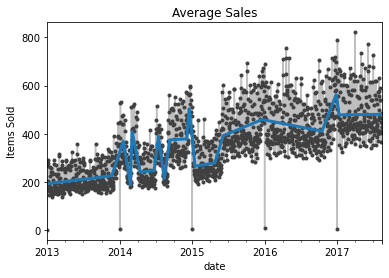

In [381]:
ax = y.plot(**plot_params, title='Average Sales', ylabel='Items Sold')
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend')

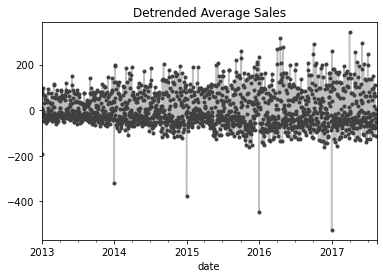

In [382]:
y_detrended = y - y_pred

y_detrended.plot(**plot_params, title='Detrended Average Sales');

## Seasonal

In [350]:
store_sales_sea = store_sales.drop(columns=['id', 'onpromotion'])
average_sales = (
    store_sales_sea.groupby('date').mean()
        .squeeze()
        .loc['2017']
)

In [351]:
average_sales = y_detrended.to_frame()
average_sales.columns = ['sales']
average_sales = (average_sales.squeeze().loc['2017'])

average_sales

date
2017-01-01   -527.197644
2017-01-02    259.302399
2017-01-03     98.466167
2017-01-04     40.685905
2017-01-05    -72.194790
                 ...    
2017-08-11    -17.837917
2017-08-12    -36.795848
2017-08-13      4.152135
2017-08-14    -54.634104
2017-08-15    -53.680291
Freq: D, Name: sales, Length: 227, dtype: float64

##### Determine seasonality

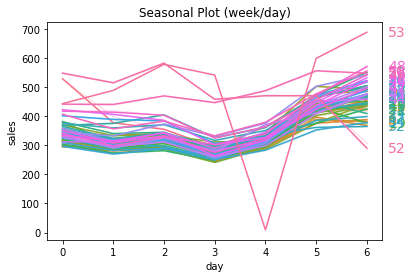

In [383]:
X = average_sales.to_frame()
X['week'] = X.index.week
X['day'] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

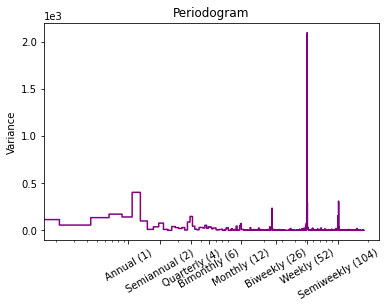

In [384]:
plot_periodogram(average_sales);

##### Create seasonal feature

In [385]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

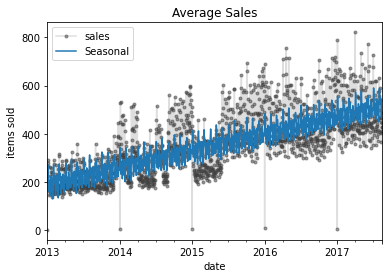

In [386]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
)

ax = y.plot(**plot_params, alpha=0.5, title='Average Sales', ylabel='items sold')
ax = y_pred.plot(ax=ax, label='Seasonal')
ax.legend();

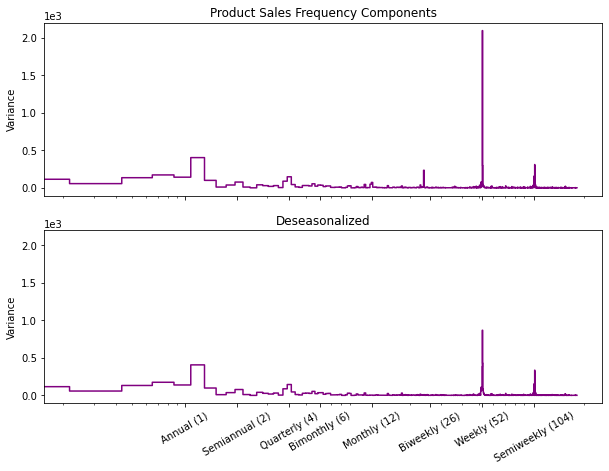

In [387]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title('Product Sales Frequency Components')
ax2 = plot_periodogram(y_deseason, ax=ax2)
ax2.set_title('Deseasonalized');

In [388]:
holidays_events = pd.read_csv(
    'store-sales-time-series-forecasting\\holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'local_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')
holidays = (
    holidays_events
        .query('locale in ["National", "Regional"]')
        .loc['2017': '2017-08-15', ['description']]
)

# display(holidays)

Text(0.5, 1.0, 'National and Regional Holidays')

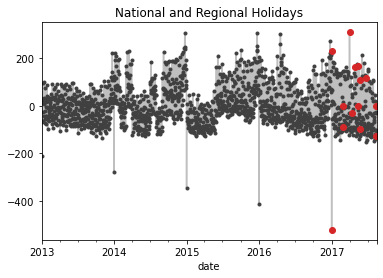

In [389]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays')

##### Create holiday features

In [359]:
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)

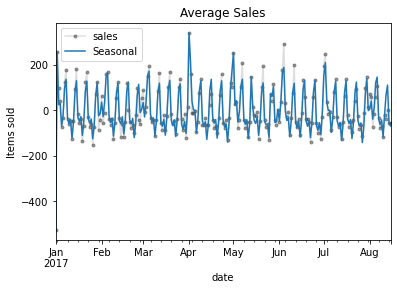

In [360]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

ax = y.plot(**plot_params, alpha=0.5, title='Average Sales', ylabel='Items sold')
ax = y_pred.plot(ax=ax, label='Seasonal')
ax.legend();

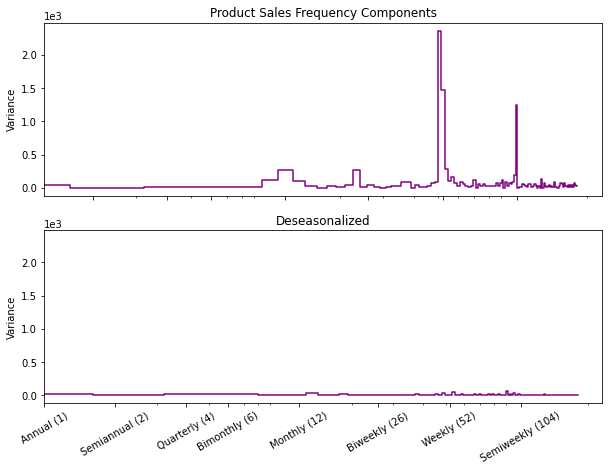

In [361]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

### Time Series as Features

In [362]:
temp_store_sales = store_sales.drop(columns=['id'])

family_sales = (
    store_sales
        .groupby(['family', 'date'])
        .mean()
        .unstack('family')
        .loc['2017', ['sales', 'onpromotion']]
)

# family_sales

### Hybrid Models

In [363]:
store_sales_hybrid = store_sales.drop('id', axis=1)

In [364]:
y = family_sales.loc[:, 'sales']

dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()

X_2 = family_sales.drop('sales', axis=1).stack()

le = LabelEncoder()
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

X_2["day"] = X_2.index.day

In [365]:
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)

model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

In [366]:
# Model 1 (trend)
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

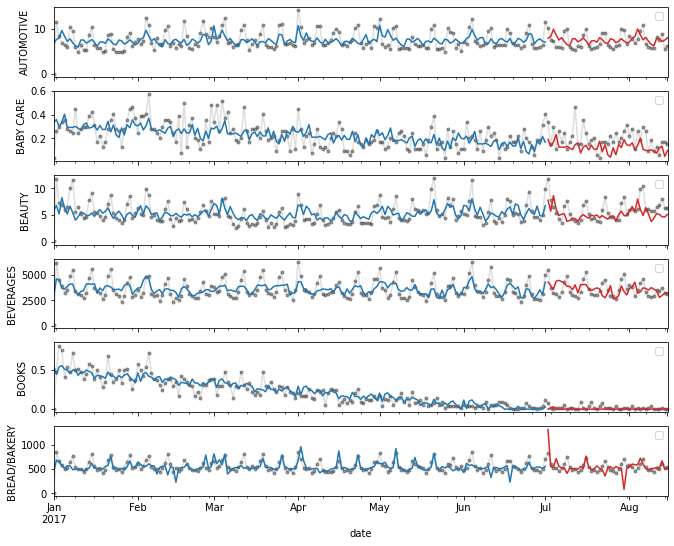

In [367]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02":]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

### Forecasting With Machine Learning

In [368]:
test = pd.read_csv(
    'store-sales-time-series-forecasting//test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [369]:
print("Training Data", "\n" + "-" * 13)
store_sales

Training Data 
-------------


id        sales  \
date       store_nbr family                                             
2013-01-01 1         AUTOMOTIVE                        0     0.000000   
                     BABY CARE                         1     0.000000   
                     BEAUTY                            2     0.000000   
                     BEVERAGES                         3     0.000000   
                     BOOKS                             4     0.000000   
...                                                  ...          ...   
2017-08-15 9         POULTRY                     3000883   438.132996   
                     PREPARED FOODS              3000884   154.552994   
                     PRODUCE                     3000885  2419.729004   
                     SCHOOL AND OFFICE SUPPLIES  3000886   121.000000   
                     SEAFOOD                     3000887    16.000000   

                                                 onpromotion  
date       store_nbr family                                   
2013-01-01 1         AUTOMOTIVE                            0  
                     BABY CARE                             0  
                     BEAUTY                                0  
                     BEVERAGES                             0  
                     BOOKS                                 0  
...                                                      ...  
2017-08-15 9         POULTRY                               0  
                     PREPARED FOODS                        1  
                     PRODUCE                             148  
                     SCHOOL AND OFFICE SUPPLIES            8  
                     SEAFOOD                               0  

[3000888 rows x 3 columns]

In [370]:
print("Test Data", "\n" + "-" * 9)
test

Test Data 
---------


id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...                                  ...          ...
9         SEAFOOD    2017-08-27  3022271            0
                     2017-08-28  3024053            0
                     2017-08-29  3025835            0
                     2017-08-30  3027617            0
                     2017-08-31  3029399            0

[28512 rows x 2 columns]

In [371]:
y = family_sales.loc[:, 'sales']

X = make_lags(y, lags=4).dropna()
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

In [373]:
le = LabelEncoder()
X = (X
     .stack('family')
     .reset_index('family')
     .assign(family=lambda x: le.fit_transform(x.family))
     )
y = y.stack('family')

In [ ]:
x

In [374]:
# model = RegressorChain(base_estimator=XGBRegressor())
#
# model.fit(X, y)
#
# y_pred = pd.DataFrame(
#     model.predict(X),
#     index=y.index,
#     columns=y.columns,
# ).clip(0.0)

In [375]:
# Model 1 (trend)
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=RegressorChain(base_estimator=XGBRegressor()),
)

model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

ValueError: Found input variables with inconsistent numbers of samples: [227, 7491]

In [ ]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02":]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

In [ ]:
FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])